### CNN 2nd Version full model (improve from 10-class model)
- Loss plateaued after ~50 epochs, with validation accuracy stuck below 2%.
- Likely causes:
     - L1/L2 regularization may be too strong for a 120-class classification task.
     - Learning rate decay might be too aggressive, preventing further learning after early epochs.
- Improvement from 10-class classification:
    - Reduced L1 and L2 regularization to 1e-5 and 1e-4 from 0.01 in 10-class model
    - Increased decay to 0.9 from 0.8
    - Batch size increased to 32 to speed up training (from 16 in 10-class)

In [ ]:
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers
import keras_tuner as kt

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# plots
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
with open("../data/processed/processed_full_dataset.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())

# load data for the full dataset
X_train = data['X_train_bbox'] 
y_train = data['y_train_bbox']
X_val = data['X_val_bbox']
y_val = data['y_val_bbox']
X_test = data['X_test_bbox']
y_test = data['y_test_bbox']

# full dataset
breed = data['classes_bbox']

num_breeds = len(breed)
breed_ids = [i for i in range(len(breed))]
breed_id_map = {breed[i]:i for i in range(len(breed))}
id_breed_map = {id: label for label, id in breed_id_map.items()}
y_train = np.array([breed_id_map[x] for x in y_train])
y_val = np.array([breed_id_map[x] for x in y_val])
y_test = np.array([breed_id_map[x] for x in y_test])

print(breed[:10])

dict_keys(['X_train_bbox', 'y_train_bbox', 'X_val_bbox', 'y_val_bbox', 'X_test_bbox', 'y_test_bbox', 'classes_bbox'])
['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle']


In [ ]:
# Check class balance: count the number of categories per class

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
unique_elements, counts = np.unique(y_train, return_counts=True)
unique_elements_val, counts_val = np.unique(y_val, return_counts=True)

print(f"Check class balance in train: {counts}")
print(f"Check class balance in val: {counts_val}")

X_train shape: (12000, 64, 64, 3)
X_val shape: (4290, 64, 64, 3)
Check class balance in train: [100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100]
Check class balance in val: [25 69 34 51 32 25 48 55 37 48 41 59 30 44 44 35 25 36 26 41 25 26 27 26
 26 28 48 28 34 26 48 25 29 26 26 40 25 28 25 29 30 30 51 25 26 30 26 26
 28 25 26 28 56 34 25 44 28 35 25 59 41 42 29 27 40 27 25 36 49 55 43 39
 25 76 27 42 28 27 48 36 48 42 34 25 48 24 40 60 50 24 36 26 35 50 59 27
 29 66 51 28 57 46 41 28 28 30 27 25 26 53 26 36 27 26 30 25 34 44 28 32]


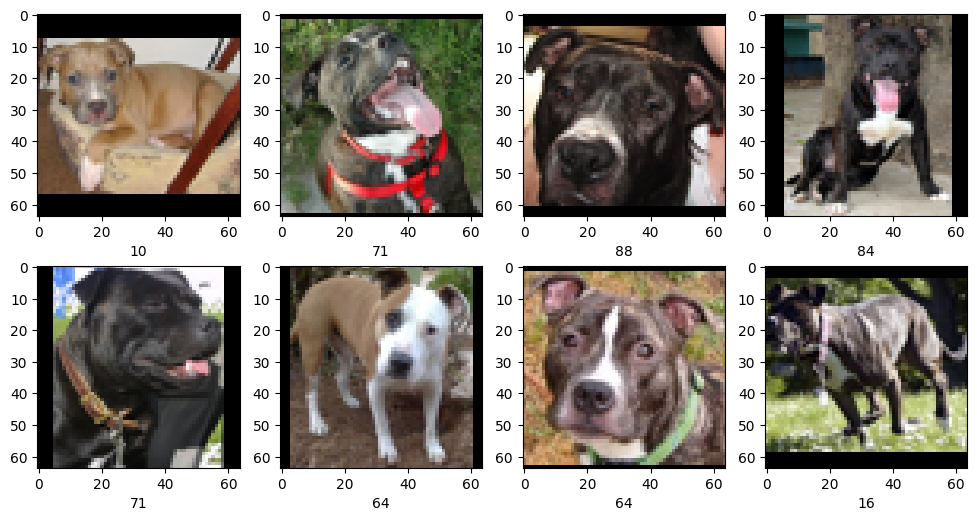

In [ ]:
# Visualize images of a certain breed

cols = 4
ind = [i for i, val in enumerate(y_train) if val == breed_id_map['american_staffordshire_terrier']]
# ind = [i for i, val in enumerate(y_val) if val =='norwegian_elkhound']

plt.figure(figsize=(cols * 3, 6)) 
for i in range(8):
    plt.subplot(2, cols, i + 1)
    plt.grid(False)
    img = array_to_img(X_train[ind[i]])
    plt.imshow(img)
    plt.xlabel(y_val[ind[i]])
plt.show()

In [146]:
def plot_acc_loss(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Plot Train Loss
    axes[0].plot(history.history['loss'], label='Train Loss', color='tab:blue')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', color='tab:orange')
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Plot Validation Loss
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', color='tab:blue')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:orange')
    axes[1].set_title("Accuracy")  
    axes[1].set_xlabel("Epoch")
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle("Loss in CNN", fontsize=12)
    plt.tight_layout()
    plt.show()

### Model building - CNN
- random augmentation layer <-- helps model generalization
- convo + pooling + batchnorm + convo + pooling + batchnorm + convo + convo + pooling

In [ ]:
# initialize CNN model
class ManualCNN(tf.keras.Model):
    def __init__(self, num_classes=n_breed):
        super().__init__()
        
        # re-generate random augumentation for each epoch
        self.preproc = tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.2),
                tf.keras.layers.RandomZoom(0.2),
                tf.keras.layers.RandomBrightness(0.2, (0.0, 1.0)),
                tf.keras.layers.RandomContrast(0.2)
            ])
        
        self.L1 = 1e-5
        self.L2 = 1e-4
        self.max_pool = 2
        self.activation = 'relu'

        self.conv1 = tf.keras.layers.Conv2D(8, (8, 8), activation=self.activation, padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(self.L1, self.L2))
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=self.max_pool, strides=(2, 2), padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(16, (4, 4), activation=self.activation, padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(self.L1, self.L2))
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=self.max_pool, strides=(2, 2), padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2D(16, (2, 2), activation=self.activation, padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(self.L1, self.L2))

        self.conv4 = tf.keras.layers.Conv2D(16, (2, 2), activation=self.activation, padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(self.L1, self.L2))
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=self.max_pool, strides=(2, 2), padding='same')

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation=self.activation)
        self.fc2 = tf.keras.layers.Dense(128, activation=self.activation)
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.out = tf.keras.layers.Dense(num_classes, activation='softmax')

    # use a call function to  apply augmentation only to the training set
    def call(self, inputs, training=False):
        if training:
            x = tf.keras.layers.Lambda(lambda t: self.preproc(t, training=True))(inputs)
        else:
            x = inputs
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x, training=training)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x, training=training)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dropout(x, training=training)
        return self.out(x)

Epoch 1/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.0116 - loss: 4.7891 - val_accuracy: 0.0247 - val_loss: 4.5505
Epoch 2/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.0302 - loss: 4.5072 - val_accuracy: 0.0359 - val_loss: 4.4110
Epoch 3/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.0338 - loss: 4.3805 - val_accuracy: 0.0513 - val_loss: 4.2199
Epoch 4/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.0442 - loss: 4.2590 - val_accuracy: 0.0611 - val_loss: 4.1925
Epoch 5/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.0476 - loss: 4.2076 - val_accuracy: 0.0606 - val_loss: 4.1652
Epoch 6/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.0549 - loss: 4.1726 - val_accuracy: 0.0751 - val_loss: 4.0337
Epoch 7/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.0612 - loss: 4.0868 - val_accuracy: 0.0790 - val_loss: 3.9887
Epoch 8/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.0636 - loss: 4

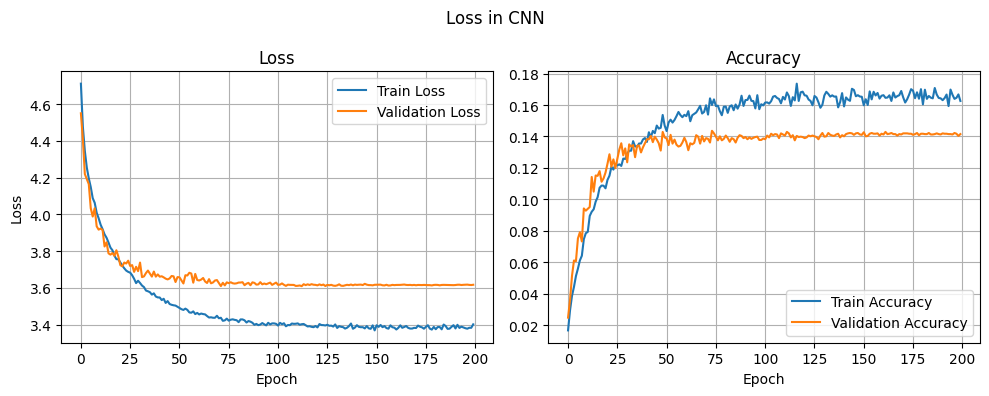


Train Accuracy: 0.1626, Validation Accuracy: 0.1415


In [ ]:
tf.keras.backend.clear_session()
model = ManualCNN(num_classes=num_breeds)

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=1
)

plot_acc_loss(history)

print(f"")
# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_acc = history.history['accuracy'][-1]
val_acc =  history.history['val_accuracy'][-1]
print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

In [207]:
tf.keras.backend.clear_session()
final_model = ManualCNN(num_classes=num_breeds)

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

final_model_hist = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=75,
    batch_size=32,
    verbose=1
)

Epoch 1/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.0086 - loss: 4.8098 - val_accuracy: 0.0242 - val_loss: 4.6208
Epoch 2/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.0245 - loss: 4.5593 - val_accuracy: 0.0429 - val_loss: 4.3517
Epoch 3/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.0375 - loss: 4.3730 - val_accuracy: 0.0452 - val_loss: 4.2866
Epoch 4/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.0414 - loss: 4.2940 - val_accuracy: 0.0464 - val_loss: 4.2661
Epoch 5/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.0471 - loss: 4.2237 - val_accuracy: 0.0634 - val_loss: 4.0922
Epoch 6/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.0535 - loss: 4.1713 - val_accuracy: 0.0669 - val_loss: 4.0655
Epoch 7/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.0550 - loss: 4.1462 - val_accuracy: 0.0755 - val_loss: 4.0180
Epoch 8/75
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.0631 - loss: 4.0706 - 

In [208]:
# Output Model Summary
final_model.build(input_shape=(None, 64, 64, 3))
final_model.summary()

Model: "manual_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 64, 64, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 64, 64, 8)        │         1,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 32, 32, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 32, 32, 16)       │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 16, 16, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 16, 16, 16)       │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 16, 16, 16)       │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 120)              │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,833 (1.93 MB)

 Trainable params: 168,928 (659.88 KB)

 Non-trainable params: 48 (192.00 B)

 Optimizer params: 337,857 (1.29 MB)

### Model evaluation

In [209]:
predicted = final_model.predict(X_test)
predicted_labels = [np.argmax(predicted[i]) for i in range(predicted.shape[0])]

print(classification_report(y_test, predicted_labels))

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.15      0.28      0.19        25
           1       0.31      0.16      0.21        70
           2       0.19      0.51      0.28        35
           3       0.19      0.10      0.13        51
           4       0.00      0.00      0.00        32
           5       0.17      0.23      0.19        26
           6       0.17      0.06      0.09        48
           7       0.21      0.13      0.16        54
           8       0.20      0.18      0.19        38
           9       0.18      0.04      0.07        47
          10       0.17      0.32      0.22        41
          11       0.33      0.19      0.24        59
          12       0.05      0.07      0.06        29
          13       0.26      0.32      0.29        44
          14       0.17      0.19      0.18        43
          15       0.05      0.03      0.04        36
          16       0.11      0.32      0

/home/lyn/miniconda3/envs/dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/lyn/miniconda3/envs/dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/lyn/miniconda3/envs/dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

### Subgroup Analysis

In [210]:
# Calculate error rate for each breed (error rate = misclassified/total count)

cm = confusion_matrix(y_test, predicted_labels)
mistakes = cm.sum(axis=1) - np.diag(cm)
mistake_df = pd.DataFrame(mistakes, columns=['mistakes'], index = breed)
mistake_df['total'] = cm.sum(axis=1)
mistake_df['error_rate'] = round(mistake_df['mistakes']/mistake_df['total'],2)
sorted_by_error_rate = mistake_df.sort_values(by='error_rate',ascending=False)
top_misclassified = list(sorted_by_error_rate.head(10).index)
sorted_by_error_rate

,mistakes,total,error_rate
american_staffordshire_terrier,32,32,1.00
boxer,25,25,1.00
briard,26,26,1.00
golden_retriever,25,25,1.00
cocker_spaniel,30,30,1.00
...,...,...,...
komondor,16,27,0.59
sealyham_terrier,27,51,0.53
greater_swiss_mountain_dog,17,34,0.50
sussex_spaniel,13,26,0.50


/tmp/ipykernel_1741735/477555186.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_misclassified, x='count', y='breed', palette='Reds_r')


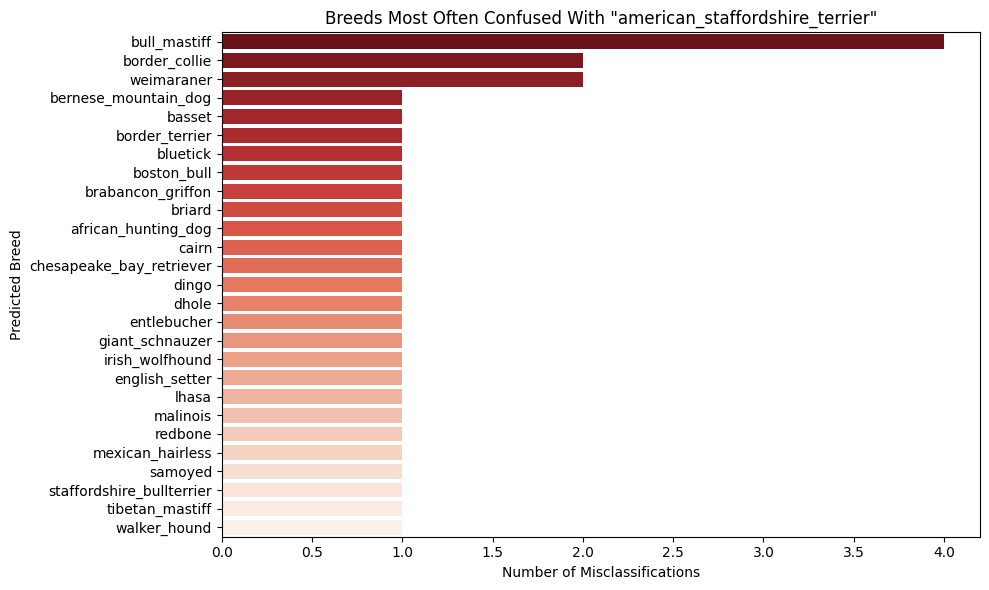

In [211]:
# Plot the top misclassified classes

breed_name = 'american_staffordshire_terrier'
misclas_breed_idx = breed_id_map[breed_name]
cm_by_breed = cm[misclas_breed_idx]

cm_by_breed[misclas_breed_idx] = 0  # zero out diagonal
nonzero_indices = np.where(cm_by_breed > 0)[0]
nonzero_counts = cm_by_breed[nonzero_indices]
nonzero_breeds = [id_breed_map[i] for i in nonzero_indices]

# Create a DataFrame for plotting
df_misclassified = pd.DataFrame({
    'breed': nonzero_breeds,
    'count': nonzero_counts
}).sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_misclassified, x='count', y='breed', palette='Reds_r')
plt.title(f'Breeds Most Often Confused With "{breed_name}"')
plt.xlabel('Number of Misclassifications')
plt.ylabel('Predicted Breed')
plt.tight_layout()
plt.show()

In [ ]:
## plot confusion matrix

# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=breed)
# fig, ax = plt.subplots(figsize=(10, 8))
# disp.plot(cmap='GnBu', ax=ax, xticks_rotation=90)
# plt.title('Confusion Matrix')
# plt.show()

In [212]:
# Evaluate test set
test_loss, test_acc = model.evaluate(X_test,y_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1653 - loss: 3.5288
Test Loss: 3.5017, Test Accuracy: 0.1667
